In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

In [3]:
df = pd.read_csv("KaggleV2-May-2016.csv")

In [4]:
initial_rows = len(df)
initial_rows

110527

### Creating new features

In [5]:
df.PatientId = df.PatientId.astype('string')
df.AppointmentID = df.AppointmentID.astype('string')
df.AppointmentDay = df.AppointmentDay.apply(lambda x: pd.Timestamp(x))
df.ScheduledDay = df.ScheduledDay.apply(lambda x: pd.Timestamp(x))
df['time_delta'] = df.AppointmentDay - df.ScheduledDay
df['time_delta_weeks'] = df['time_delta'].apply(lambda x: (x.days+1)//7)
df['time_delta_days'] = df['time_delta'].apply(lambda x: x.days+1)
df['Appointment_weekday'] = df['AppointmentDay'].apply(lambda x: x.weekday)
df['Age_decade'] = df['Age'].apply(lambda x: x // 10)
df['No-show_bin'] = df['No-show'].apply(lambda x: 1 if x=='Yes' else 0)
df['Handcap'] = df['Handcap'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'time_delta', 'time_delta_weeks', 'time_delta_days',
       'Appointment_weekday', 'Age_decade', 'No-show_bin'],
      dtype='object')

In [7]:
# dates
print(df.AppointmentDay.max())
print(df.AppointmentDay.min())

2016-06-08 00:00:00+00:00
2016-04-29 00:00:00+00:00


In [8]:
# treatment
df['SMS_received'].mean()

0.32102563174608917

In [9]:
# outcome
df['No-show_bin'].mean()

0.20193255946510807

In [10]:
# Gender
df['Gender'].value_counts(normalize=True)

F    0.649977
M    0.350023
Name: Gender, dtype: float64

In [11]:
# same day appoitments
df['time_delta_days'].value_counts(normalize=True).sort_index()

-6      0.000009
-1      0.000036
 0      0.348901
 1      0.047165
 2      0.060845
          ...   
 155    0.000090
 162    0.000100
 169    0.000072
 176    0.000145
 179    0.000090
Name: time_delta_days, Length: 131, dtype: float64

In [12]:
print("no-show same day")
print(df[df['time_delta_days']<1]['No-show_bin'].mean())
print("sms recived same day")
print(df[df['time_delta_days']<3]['SMS_received'].mean())

no-show same day
0.046593030491599255
sms recived same day
0.0


Text(0.5, 0, 'Age')

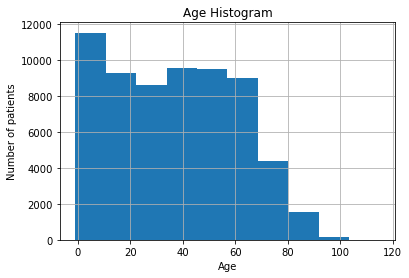

In [13]:
df[['PatientId','Age']].drop_duplicates()['Age'].hist()
plt.title('Age Histogram')
plt.ylabel('Number of patients')
plt.xlabel('Age')

In [14]:
# how many people have more than one appoitment?
app_count = df.groupby('PatientId').count()
app_count['AppointmentID'].describe()

count    62299.000000
mean         1.774138
std          1.770324
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         88.000000
Name: AppointmentID, dtype: float64

## Data Cleaning

In [15]:
# do we have duplicate records?
tmp = df.groupby('AppointmentID').count()
tmp[tmp.PatientId>1]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,time_delta,time_delta_weeks,time_delta_days,Appointment_weekday,Age_decade,No-show_bin
AppointmentID,,,,,,,,,,,,,,,,,,,


### Step 1: removing appointments schedualed less than 3 days in advance

In [16]:
cleaned_df = df[df['time_delta_days']>=3]
print(len(cleaned_df))

60021


### Step 2: removing young children

In [17]:
cleaned_df = cleaned_df[cleaned_df.Age>14].copy()
print(len(cleaned_df))

48003


### Step 3: removing outliers - people older than 100 or time delts weeks < 14

In [18]:
cleaned_df = cleaned_df[(cleaned_df.time_delta_weeks < 14)&(cleaned_df.Age < 100)].copy()
print(len(cleaned_df))

47870


### Step 4: reamaning patients with more than one appointment

In [19]:
app_count = cleaned_df.groupby('PatientId').count()
app_count['AppointmentID'].describe()

count    31846.000000
mean         1.503172
std          1.065468
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: AppointmentID, dtype: float64

In [20]:
print("How many patients have more than 1 appoitment record?")
print(len(app_count[app_count.AppointmentID>1])/len(app_count))

How many patients have more than 1 appoitment record?
0.29758839414683164


In [21]:
app_count1 = app_count[app_count.AppointmentID<2]
app_count2 = app_count[app_count.AppointmentID>1]

In [22]:
print("One appointment no-show:")
print(cleaned_df[cleaned_df.PatientId.isin(app_count1.reset_index().PatientId)]['No-show_bin'].mean())
print("more than one appointment no-show:")
print(cleaned_df[cleaned_df.PatientId.isin(app_count2.reset_index().PatientId)]['No-show_bin'].mean())

One appointment no-show:
0.27940453305914437
more than one appointment no-show:
0.29908631034077093


In [23]:
# how many will be removed if we will remove all with more than 1 appointments
len(cleaned_df[cleaned_df.PatientId.isin(app_count2.reset_index().PatientId)])/len(cleaned_df)

0.5327135993315228

#### randomly choosing an appointment 

In [24]:
cleaned_df = cleaned_df.groupby("PatientId").sample(n=1, random_state=42).copy()

In [310]:
cleaned_df.to_csv("final_clean_df.csv")

In [25]:
print(len(cleaned_df))

31846


In [26]:
# treatment
cleaned_df['SMS_received'].mean()

0.6043773158324436

In [27]:
# outcome
cleaned_df['No-show_bin'].mean()

0.2862839917101049

#### more exploration

<AxesSubplot:xlabel='Age_decade', ylabel='No_show_up_%'>

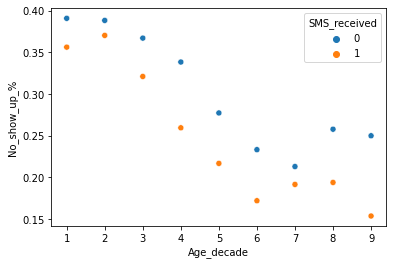

In [69]:
df_sum = cleaned_df.groupby(["Age_decade",'SMS_received',"No-show"]).agg({"PatientId":"count"}).reset_index()
df_sum = pd.pivot(df_sum ,index=['Age_decade',"SMS_received"], columns="No-show", values="PatientId")
df_sum = df_sum.dropna()
df_sum['total'] = df_sum['No'] + df_sum['Yes']
df_sum['No_show_up_%'] = df_sum['Yes']/df_sum['total']
df_sum = df_sum.reset_index()
sns.scatterplot(data=df_sum, x="Age_decade",y='No_show_up_%',hue='SMS_received')

In [62]:
df_sum

,Age,SMS_received,PatientId
0,15,0,106
1,15,1,149
2,16,0,141
3,16,1,175
4,17,0,118
...,...,...,...
161,95,1,3
162,96,0,2
163,97,0,5
164,98,0,1


# Balancing

In [28]:
treated = cleaned_df[cleaned_df['SMS_received'] == 1]
control = cleaned_df[cleaned_df['SMS_received'] == 0]

In [29]:
def column_balance(df, column):
    counts = df.groupby(['SMS_received', column]).count().PatientId
    percentages = counts.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2)).copy()
    counts.rename('No.', inplace=True)
    percentages.rename("%", inplace=True)
    balance = pd.concat([counts, percentages], axis=1).reset_index()
    balance = pd.melt(balance, id_vars=['SMS_received',column], value_vars =['No.','%'])
    balance = pd.pivot_table(balance, index=column, columns=['SMS_received', 'variable'])
    return balance

In [140]:
def column_balance_prop(df, column):
    
    percentages = df.groupby(['SMS_received', column]).agg({'est':'sum'}).copy()
    balance = percentages.reset_index()
    balance = pd.pivot_table(balance, index=column, columns=['SMS_received'], values='est')
    balance[0] = balance[0]/sum(balance[0])
    balance[1] = balance[1]/sum(balance[1])

    return balance

In [133]:
def chi_square_test(df, column):
    counts = df.groupby(['SMS_received', column]).count().PatientId
    counts = pd.DataFrame(counts)
    pivoted = pd.pivot_table(counts, index='SMS_received', columns=column)
    chi2, p_value = chi2_contingency(pivoted)[:2]
    res = pd.DataFrame(data=[[round(chi2,2), p_value]], columns=['Chi Square','p value'], index=[column])
    res['p value'] = res['p value'].apply(lambda x: round(x, 3) if x>=0.005 else '<0.005')
    return res

In [134]:
def chi_square_test_prop(pivoted, column):
    chi2, p_value = chi2_contingency(pivoted)[:2]
    res = pd.DataFrame(data=[[round(chi2,2), p_value]], columns=['Chi Square','p value'], index=[column])
    res['p value'] = res['p value'].apply(lambda x: round(x, 3) if x>=0.005 else '<0.005')
    return res

In [135]:
cat_columns = ['Gender', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'time_delta_weeks', 'Age_decade', 'No-show']

In [136]:
def print_balance_table(df, columns=cat_columns):
    df_list = []
    chi_list = []
    for column in columns:
        df_list.append(column_balance(df, column))
        chi_list.append(chi_square_test(df, column))
    balance = pd.concat(df_list, keys=cat_columns)
    chi = pd.concat(chi_list, keys=cat_columns)
    return balance, chi

In [137]:
def print_balance_table_est(df, est, columns=cat_columns):
    df_list = []
    chi_list = []
    df['est'] = est
    for column in columns:
        pivoted = column_balance_prop(df, column)
        df_list.append(pivoted)
        chi_list.append(chi_square_test_prop(pivoted.T, column))
    balance = pd.concat(df_list, keys=cat_columns)
    chi = pd.concat(chi_list, keys=cat_columns)
    return balance, chi

In [36]:
original_balance, original_chi = print_balance_table(cleaned_df)
original_balance

value                         
SMS_received              0               1         
variable                  %      No.      %      No.
Gender           F    68.66   8650.0  71.69  13798.0
                 M    31.34   3949.0  28.31   5449.0
Scholarship      0    91.36  11511.0  90.58  17433.0
                 1     8.64   1088.0   9.42   1814.0
Hipertension     0    73.68   9283.0  75.77  14583.0
                 1    26.32   3316.0  24.23   4664.0
Diabetes         0    90.95  11459.0  91.68  17646.0
                 1     9.05   1140.0   8.32   1601.0
Alcoholism       0    96.71  12185.0  97.20  18709.0
                 1     3.29    414.0   2.80    538.0
Handcap          0    97.87  12331.0  98.20  18900.0
                 1     2.13    268.0   1.80    347.0
time_delta_weeks 0    28.72   3618.0  25.09   4829.0
                 1    20.45   2576.0  21.12   4065.0
                 2    16.09   2027.0  15.55   2993.0
                 3    11.22   1413.0  12.53   2411.0
                 4    11.54   1454.0  10.33   1989.0
                 5     4.01    505.0   5.39   1037.0
                 6     2.06    259.0   2.51    483.0
                 7     1.47    185.0   1.72    332.0
                 8     1.10    138.0   2.08    400.0
                 9     1.20    151.0   1.97    380.0
                 10    1.22    154.0   0.77    149.0
                 11    0.55     69.0   0.12     23.0
                 12    0.26     33.0   0.65    126.0
                 13    0.13     17.0   0.16     30.0
Age_decade       1     7.98   1006.0   7.51   1446.0
                 2    14.87   1873.0  16.07   3093.0
                 3    16.20   2041.0  17.29   3327.0
                 4    15.39   1939.0  16.24   3125.0
                 5    18.23   2297.0  18.85   3629.0
                 6    14.18   1787.0  14.30   2753.0
                 7     8.23   1037.0   6.61   1273.0
                 8     4.31    543.0   2.78    536.0
                 9     0.60     76.0   0.34     65.0
No-show          No   68.58   8640.0  73.20  14089.0
                 Yes  31.42   3959.0  26.80   5158.0

In [357]:
original_balance.to_csv('original_balance.csv')

In [37]:
original_chi

,,Chi Square,p value
Gender,Gender,33.52,<0.005
Scholarship,Scholarship,5.63,0.018
Hipertension,Hipertension,17.55,<0.005
Diabetes,Diabetes,5.07,0.024
Alcoholism,Alcoholism,6.16,0.013
Handcap,Handcap,4.06,0.044
time_delta_weeks,time_delta_weeks,260.91,<0.005
Age_decade,Age_decade,111.53,<0.005
No-show,No-show,79.46,<0.005


In [72]:
original_chi.to_csv('original_chi.csv')

In [38]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    counts = df.Neighbourhood.value_counts()
    percentages = df.Neighbourhood.value_counts(normalize=True)
    print((percentages[percentages > 0.02] * 100))
    

JARDIM CAMBURI       6.982004
MARIA ORTIZ          5.252110
RESISTÊNCIA          4.008975
JARDIM DA PENHA      3.507740
ITARARÉ              3.179314
CENTRO               3.016458
TABUAZEIRO           2.833697
SANTA MARTHA         2.832792
JESUS DE NAZARETH    2.581270
BONFIM               2.508889
SANTO ANTÔNIO        2.484461
SANTO ANDRÉ          2.326128
CARATOÍRA            2.320700
JABOUR               2.270034
SÃO PEDRO            2.214843
ILHA DO PRÍNCIPE     2.050178
NOVA PALESTINA       2.048368
ANDORINHAS           2.046559
DA PENHA             2.005845
ROMÃO                2.004035
Name: Neighbourhood, dtype: float64


# Methods

### help functions

In [39]:
def plot_propensity_graph(method_name, treatment, propensity_scores):
    plt.hist(propensity_scores[treatment==1], fc=(0, 0, 1, 0.5), bins=20, label='Treated')
    plt.hist(propensity_scores[treatment==0], fc=(1, 0, 0, 0.5), bins=20, label='Control')
    plt.title(method_name + " propensity scores overlap")
    plt.legend()
    plt.xlabel('propensity score')
    plt.ylabel("number of units")

In [40]:
def recalculate_balance(df, propensity_scores):
    pass

In [41]:
def calculate_odds_ratio(treated, control):
    pass

In [42]:
res_dict = {}

## Naive ATE calculation:

In [43]:
cleaned_df = cleaned_df.reset_index()

In [44]:
Y1 = np.array(cleaned_df[cleaned_df['SMS_received']==1]['No-show_bin']).mean()
Y0 = np.array(cleaned_df[cleaned_df['SMS_received']==0]['No-show_bin']).mean()
delta_all = Y1 - Y0
printmd(f"$\hat (ATE) $={round(delta_all,3)}")

$\hat (ATE) $=-0.046

In [45]:
deltas = []
B = 400
alpha = 0.05
for i in range(B): # B=400 as defined earlier
    
    temp_sample = cleaned_df.sample(n=200, replace=True) # allow selecting each row more than once
    # fitting the linear model
    temp_mu1 = np.array(temp_sample[temp_sample['SMS_received']==1]['No-show_bin']).mean()
    temp_mu0 = np.array(temp_sample[temp_sample['SMS_received']==0]['No-show_bin']).mean()
    deltas.append(temp_mu1-temp_mu0)
    
deltas.sort()
CI_0 = [deltas[int(B*(alpha/2))], deltas[int(B*(1 - alpha/2))]]
printmd("**The CI for delta is:**")
print(CI_0)

**The CI for delta is:**

[-0.18209718670076724, 0.06874745002039984]


In [46]:
res_dict['Naive ATE'] = [delta_all, CI_0]

### Calculating Propensity

In [47]:
propensity_columns = ['Gender', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'time_delta_days', 'Age', 'Neighbourhood']

In [48]:
df_propensity = cleaned_df[propensity_columns]
treatment = cleaned_df.SMS_received

#### Creating dummy variables

In [49]:
neighbourhood_dummies = pd.get_dummies(df_propensity.Neighbourhood, prefix='neighbourhood')
gender_dummies = pd.get_dummies(df_propensity.Gender, prefix='gender')
df_propensity = pd.concat((df_propensity, neighbourhood_dummies, gender_dummies), axis=1)
df_propensity.drop('Neighbourhood', inplace=True, axis=1)
df_propensity.drop('Gender', inplace=True, axis=1)

#### Scaling the Data

In [50]:
scaler = preprocessing.StandardScaler().fit(df_propensity)
df_propensity_scaled = scaler.transform(df_propensity)

#### Logistic Regression

In [51]:
logistic_clf = LogisticRegression(random_state=0).fit(df_propensity_scaled, treatment)
logistic_propensity = logistic_clf.predict_proba(df_propensity_scaled)[:, 1]

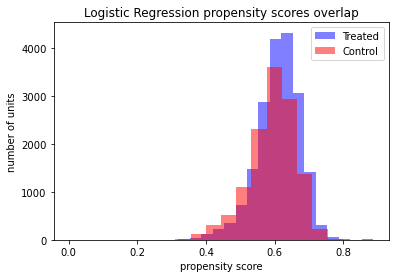

In [52]:
plot_propensity_graph("Logistic Regression", treatment, logistic_propensity)

#### Gradient Boosted Trees

In [53]:
trees_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                       max_depth=1, random_state=0).fit(df_propensity_scaled, treatment)
trees_propensity = trees_clf.predict_proba(df_propensity_scaled)[:, 1]

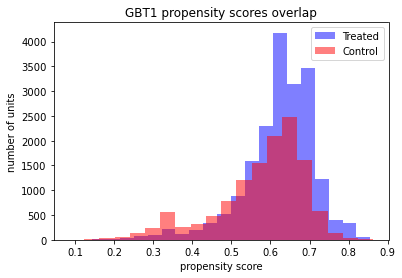

In [59]:
plot_propensity_graph("GBT1", treatment, trees_propensity)

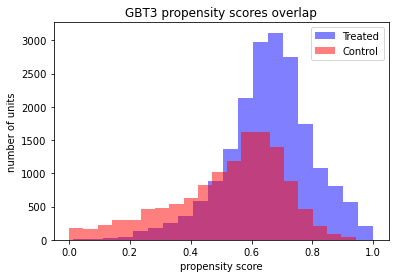

In [60]:
trees_clf_3 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                       max_depth=3, random_state=0).fit(df_propensity_scaled, treatment)
trees_propensity_3 = trees_clf_3.predict_proba(df_propensity_scaled)[:, 1]
plot_propensity_graph("GBT3", treatment, trees_propensity_3)

Logistic Regression:
	Brier: 0.235
Gradient Boosted Trees 1:
	Brier: 0.227
Gradient Boosted Trees 3:
	Brier: 0.205


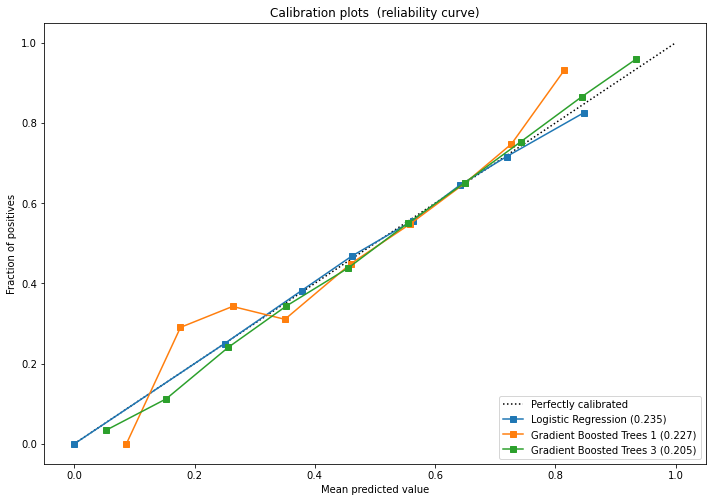

In [71]:
def plot_calibration_curve(est_dict, T):
    """Plot calibration curve for est w/o and with calibration.
    Taken from sklearn docs"""

    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for name, est in est_dict.items():
        y_pred = est

        clf_score = brier_score_loss(T, y_pred)
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(T, y_pred, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))


    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')
    ax1.set_xlabel("Mean predicted value")

    plt.tight_layout()

est_dict = {'Logistic Regression': logistic_propensity, 'Gradient Boosted Trees 1': trees_propensity, 'Gradient Boosted Trees 3': trees_propensity_3}

plot_calibration_curve(est_dict, treatment)

plt.show()

In [439]:
tmp = cleaned_df.copy()
tmp['est'] = logistic_propensity

### LR balance

In [141]:
LR_balance, LR_chi = print_balance_table_est(cleaned_df,logistic_propensity)
LR_balance

SMS_received                 0         1
Gender           F    0.699354  0.728018
                 M    0.300646  0.271982
Scholarship      0    0.910686  0.902620
                 1    0.089314  0.097380
Hipertension     0    0.746287  0.764909
                 1    0.253713  0.235091
Diabetes         0    0.912894  0.919311
                 1    0.087106  0.080689
Alcoholism       0    0.969373  0.973745
                 1    0.030627  0.026255
Handcap          0    0.980226  0.983079
                 1    0.019774  0.016921
time_delta_weeks 0    0.279927  0.241464
                 1    0.202331  0.208661
                 2    0.159423  0.155161
                 3    0.111984  0.125186
                 4    0.118359  0.106237
                 5    0.040734  0.056094
                 6    0.021551  0.025912
                 7    0.015930  0.018344
                 8    0.011698  0.022347
                 9    0.013270  0.021636
                 10   0.014070  0.008468
                 11   0.006322  0.001305
                 12   0.002896  0.007457
                 13   0.001505  0.001729
Age_decade       1    0.083958  0.078265
                 2    0.154320  0.165723
                 3    0.164923  0.175776
                 4    0.154665  0.162561
                 5    0.179176  0.185681
                 6    0.138818  0.139510
                 7    0.079058  0.063194
                 8    0.039643  0.026186
                 9    0.005440  0.003105
No-show          No   0.685394  0.730277
                 Yes  0.314606  0.269723

In [142]:
LR_chi

,,Chi Square,p value
Gender,Gender,2.31,0.129
Scholarship,Scholarship,5.81,0.016
Hipertension,Hipertension,2.61,0.106
Diabetes,Diabetes,6.42,0.011
Alcoholism,Alcoholism,17.94,<0.005
Handcap,Handcap,27.60,<0.005
time_delta_weeks,time_delta_weeks,0.02,1
Age_decade,Age_decade,0.01,1
No-show,No-show,2.21,0.138


In [143]:
GBT1_balance, GBT1_chi = print_balance_table_est(cleaned_df, trees_propensity)
GBT1_balance

SMS_received                 0         1
Gender           F    0.701952  0.729366
                 M    0.298048  0.270634
Scholarship      0    0.909818  0.903845
                 1    0.090182  0.096155
Hipertension     0    0.747804  0.766821
                 1    0.252196  0.233179
Diabetes         0    0.913460  0.920349
                 1    0.086540  0.079651
Alcoholism       0    0.969044  0.974096
                 1    0.030956  0.025904
Handcap          0    0.979832  0.982693
                 1    0.020168  0.017307
time_delta_weeks 0    0.263681  0.239137
                 1    0.214611  0.212726
                 2    0.164314  0.152804
                 3    0.117369  0.126437
                 4    0.113837  0.100842
                 5    0.043452  0.057279
                 6    0.022777  0.026154
                 7    0.016766  0.018521
                 8    0.013337  0.024778
                 9    0.013887  0.023982
                 10   0.008378  0.006961
                 11   0.002902  0.000566
                 12   0.003115  0.007962
                 13   0.001573  0.001851
Age_decade       1    0.079930  0.073412
                 2    0.154769  0.163323
                 3    0.168184  0.175952
                 4    0.158579  0.165988
                 5    0.183232  0.190526
                 6    0.140952  0.143549
                 7    0.073619  0.060084
                 8    0.036087  0.024288
                 9    0.004648  0.002878
No-show          No   0.683872  0.731040
                 Yes  0.316128  0.268960

In [144]:
GBT1_chi

,,Chi Square,p value
Gender,Gender,2.32,0.127
Scholarship,Scholarship,5.85,0.016
Hipertension,Hipertension,2.62,0.106
Diabetes,Diabetes,6.47,0.011
Alcoholism,Alcoholism,17.92,<0.005
Handcap,Handcap,27.04,<0.005
time_delta_weeks,time_delta_weeks,0.01,1
Age_decade,Age_decade,0.01,1
No-show,No-show,2.19,0.139


In [145]:
GBT3_balance, GBT3_chi = print_balance_table_est(cleaned_df, trees_propensity_3)
GBT3_balance

SMS_received                 0         1
Gender           F    0.700254  0.724799
                 M    0.299746  0.275201
Scholarship      0    0.908771  0.903316
                 1    0.091229  0.096684
Hipertension     0    0.748037  0.761953
                 1    0.251963  0.238047
Diabetes         0    0.913906  0.917923
                 1    0.086094  0.082077
Alcoholism       0    0.969678  0.973484
                 1    0.030322  0.026516
Handcap          0    0.981228  0.982623
                 1    0.018772  0.017377
time_delta_weeks 0    0.278833  0.235525
                 1    0.222133  0.205533
                 2    0.164637  0.151414
                 3    0.116279  0.129740
                 4    0.108817  0.100364
                 5    0.040563  0.061256
                 6    0.021101  0.027363
                 7    0.015536  0.017874
                 8    0.012552  0.025110
                 9    0.010909  0.024419
                 10   0.004342  0.009350
                 11   0.001451  0.001028
                 12   0.001980  0.009070
                 13   0.000867  0.001956
Age_decade       1    0.079963  0.073222
                 2    0.157250  0.161868
                 3    0.170796  0.173713
                 4    0.159347  0.165072
                 5    0.183852  0.190422
                 6    0.139596  0.145128
                 7    0.073521  0.061746
                 8    0.032194  0.025602
                 9    0.003481  0.003227
No-show          No   0.684943  0.731951
                 Yes  0.315057  0.268049

In [146]:
GBT3_chi

,,Chi Square,p value
Gender,Gender,2.32,0.128
Scholarship,Scholarship,5.81,0.016
Hipertension,Hipertension,2.63,0.105
Diabetes,Diabetes,6.44,0.011
Alcoholism,Alcoholism,17.97,<0.005
Handcap,Handcap,28.09,<0.005
time_delta_weeks,time_delta_weeks,0.03,1
Age_decade,Age_decade,0.00,1
No-show,No-show,2.20,0.138


In [147]:
GBT3_chi

,,Chi Square,p value
Gender,Gender,2.32,0.128
Scholarship,Scholarship,5.81,0.016
Hipertension,Hipertension,2.63,0.105
Diabetes,Diabetes,6.44,0.011
Alcoholism,Alcoholism,17.97,<0.005
Handcap,Handcap,28.09,<0.005
time_delta_weeks,time_delta_weeks,0.03,1
Age_decade,Age_decade,0.00,1
No-show,No-show,2.20,0.138


In [118]:
GBT3_balance.to_csv('GBT3_balance.csv')

## Estimating with IPW

In [79]:
def estimate_ATE_IPW(T, Y, e):
    n = len(T)
    left_argument = sum(T * Y/e)
    right_argument = sum(((1 - T) * Y)/(1-e))
    return (left_argument - right_argument)/n

In [80]:
def calc_bootstap_CI_IPW(df, e):
    deltas = []
    B = 400
    alpha = 0.05
    for i in range(B): # B=400 as defined earlier

        temp_sample = df.sample(n=200, replace=True) # allow selecting each row more than once
        temp_treatment = temp_sample.SMS_received
        temp_Y = temp_sample["No-show_bin"]
        temp_e = e[temp_sample.index]
        deltas.append(estimate_ATE_IPW(temp_treatment, temp_Y, temp_e))

    deltas.sort()
    CI_3 = [deltas[int(B*(alpha/2))], deltas[int(B*(1 - alpha/2))]]
    printmd("**The CI for delta is:**")
    print(CI_3)
    return CI_3

In [81]:
Y = cleaned_df["No-show_bin"]

In [82]:
print("LR:")
LR_ATE_IPW = estimate_ATE_IPW(treatment, Y, logistic_propensity)
print(LR_ATE_IPW)
CI_LR_ATE_IPW = calc_bootstap_CI_IPW(cleaned_df, logistic_propensity)
res_dict['Logistic Regression IPW'] = [LR_ATE_IPW, CI_LR_ATE_IPW]

LR:
-0.04937606975988605


**The CI for delta is:**

[-0.20318662051510045, 0.11231264941674034]


In [83]:
print("GBT:")
estimate_ATE_IPW(treatment, Y, trees_propensity)
GBT_ATE_IPW = estimate_ATE_IPW(treatment, Y, trees_propensity)
print(GBT_ATE_IPW)
CI_GBT_ATE_IPW = calc_bootstap_CI_IPW(cleaned_df, trees_propensity)
res_dict['Gradient Boosted trees 1 IPW'] = [GBT_ATE_IPW, CI_GBT_ATE_IPW]

GBT:
-0.04729860128510647


**The CI for delta is:**

[-0.21641202421964742, 0.08880123289586134]


In [84]:
print("GBT3:")
estimate_ATE_IPW(treatment, Y, trees_propensity_3)
GBT3_ATE_IPW = estimate_ATE_IPW(treatment, Y, trees_propensity_3)
print(GBT3_ATE_IPW)
CI_GBT3_ATE_IPW = calc_bootstap_CI_IPW(cleaned_df, trees_propensity_3)
res_dict['Gradient Boosted trees 3 IPW'] = [GBT3_ATE_IPW, CI_GBT3_ATE_IPW]

GBT3:
-0.04108417549594277


**The CI for delta is:**

[-0.20896182161373805, 0.12129906834694772]


## Matching with Propensity 

In [85]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels as sm
import statsmodels.api as sma
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os

def estimate_propensity(formula, data, show_summary=False):
    """ Estimates a propensity model using generalized linear models.
    
    Arguments:
    ----------
        formula:       String that contains the (R style) model formula.
        data:          DataFrame containing the covariates for each observation.
        show_summary:  Boolean that indicates to print out the model summary to the console.
    """
    model = smf.glm(formula=formula, data=data, family=sma.families.Binomial()).fit()

    if show_summary:
        print(model.summary())

    return pd.Series(data=model.predict(data), index=data.index)


def matching(label, propensity, calipher=0.05, replace=True):
    """ Performs nearest-neighbour matching for a sample of test and control
    observations, based on the propensity scores for each observation.

    Arguments:
    ----------
        label:      Series that contains the label for each observation.
        propensity: Series that contains the propensity score for each observation.
        calipher:   Bound on distance between observations in terms of propensity score.
        replace:    Boolean that indicates whether sampling is with (True) or without replacement (False).
    """

    treated = propensity[label == 1]
    control = propensity[label == 0]

    # Randomly permute in case of sampling without replacement to remove any bias arising from the
    # ordering of the data set
    matching_order = np.random.permutation(label[label == 1].index)
    matches = {}

    for obs in matching_order:
        # Compute the distance between the treatment observation and all candidate controls in terms of
        # propensity score
        distance = abs(treated[obs] - control)

        # Take the closest match
        if distance.min() <= calipher or not calipher:
            matches[obs] = [distance.argmin()]
            
            # Remove the matched control from the set of candidate controls in case of sampling without replacement
            if not replace:
                control = control.drop(matches[obs])

    return matches

                            
def matching_to_dataframe(match, covariates, remove_duplicates=False):
    """ Converts a list of matches obtained from matching() to a DataFrame.
    Duplicate rows are controls that where matched multiple times.

    Arguments:
    ----------
        match:              Dictionary with a list of matched control observations.
        covariates:         DataFrame that contains the covariates for the observations.
        remove_duplicates:  Boolean that indicates whether or not to remove duplicate rows from the result. 
                            If matching with replacement was used you should set this to False****
    """
    treated = list(match.keys())
    control = [ctrl for matched_list in match.values() for ctrl in matched_list]

    result = pd.concat([covariates.loc[treated], covariates.loc[control]])

    if remove_duplicates:
        return result.groupby(result.index).first()
    else:
        return result
     

def trim_common_support(data, label_name):
    """ Removes observations that fall outside the common support of the propensity score 
        distribution from the data.
    
    Arguments:
    ----------
        data:        DataFrame with the propensity scores for each observation.
        label_name:  Column name that contains the labels (treatment/control) for each observation.
    
    """
    group_min_max = (data.groupby(label_name)
                         .propensity.agg({"min_propensity": np.min, "max_propensity": np.max}))

    # Compute boundaries of common support between the two propensity score distributions
    min_common_support = np.max(group_min_max.min_propensity)
    max_common_support = np.min(group_min_max.max_propensity)

    common_support = (data.propensity >= min_common_support) & (data.propensity <= max_common_support)
    control = (data[label_name] == 0)
    treated = (data[label_name] == 1)
    
    return data[common_support]

def qq_plot(x, y, variable_name):
    """ Produces a QQ-plot where the percentiles of two empirical distributions are compared against each other.
    
    Arguments:
    ----------
        x:              Vector with samples from the first distribution.
        y:              Vector with samples from the second distribution.
        variable_name:  Name of the variable.
    
    """
    q = np.arange(0, 100)
    a = np.percentile(a=x, q=q)
    b = np.percentile(a=y, q=q)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title("QQ-plot of variable %s" % variable_name)
        
    plt.plot(a, b, 'o')
    plt.plot([0, np.max(a)], [0, np.max(a)], '-')
    
    ax.set_xlabel("Control quantiles")
    ax.set_ylabel("Treatment quantiles")

In [86]:
treatment

0        1
1        1
2        1
3        1
4        1
        ..
31841    1
31842    1
31843    1
31844    1
31845    1
Name: SMS_received, Length: 31846, dtype: int64

In [87]:
logistic_propensity_sr = pd.Series(logistic_propensity).rename("propensity", inplace=True)
df_LR = cleaned_df.join(logistic_propensity_sr)

In [88]:
matches_LR = matching(label=treatment,
                   propensity=logistic_propensity_sr,
                   calipher=0.1,
                   replace=True)

SMS_received
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

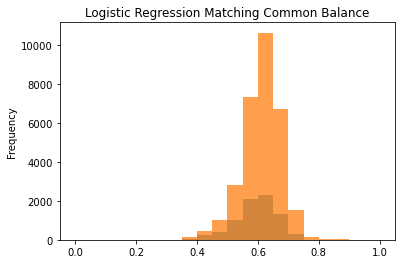

In [89]:
matches_data_frame_LR = matching_to_dataframe(match=matches_LR,
                                           covariates=df_LR,
                                           remove_duplicates=False)

matches_data_frame_LR.groupby("SMS_received")["propensity"].plot(kind="hist", sharex=True, range=(0,1), bins=20, alpha=0.75, title="Logistic Regression Matching Common Balance")

In [90]:
LR_balance_table, LR_balance_chi = print_balance_table(matches_data_frame_LR)
LR_balance_table

value                        
SMS_received              0              1         
variable                  %     No.      %      No.
Gender           F    69.36  5330.0  71.16  21925.0
                 M    30.64  2355.0  28.84   8884.0
Scholarship      0    90.58  6961.0  90.73  27953.0
                 1     9.42   724.0   9.27   2856.0
Hipertension     0    73.62  5658.0  75.86  23373.0
                 1    26.38  2027.0  24.14   7436.0
Diabetes         0    91.57  7037.0  91.63  28231.0
                 1     8.43   648.0   8.37   2578.0
Alcoholism       0    96.53  7418.0  97.26  29966.0
                 1     3.47   267.0   2.74    843.0
Handcap          0    98.06  7536.0  98.28  30280.0
                 1     1.94   149.0   1.72    529.0
time_delta_weeks 0    27.33  2100.0  24.93   7681.0
                 1    22.06  1695.0  21.49   6622.0
                 2    14.87  1143.0  15.51   4780.0
                 3    10.70   822.0  12.22   3764.0
                 4    11.84   910.0  10.64   3277.0
                 5     3.98   306.0   5.36   1651.0
                 6     2.17   167.0   2.31    712.0
                 7     1.68   129.0   1.80    554.0
                 8     1.29    99.0   2.13    655.0
                 9     1.61   124.0   1.99    612.0
                 10    1.55   119.0   0.75    230.0
                 11    0.43    33.0   0.11     34.0
                 12    0.35    27.0   0.62    191.0
                 13    0.14    11.0   0.15     46.0
Age_decade       1     8.71   669.0   7.54   2322.0
                 2    14.50  1114.0  16.08   4953.0
                 3    16.58  1274.0  17.24   5310.0
                 4    16.56  1273.0  16.58   5109.0
                 5    17.46  1342.0  18.48   5695.0
                 6    13.72  1054.0  14.56   4485.0
                 7     7.39   568.0   6.45   1987.0
                 8     4.42   340.0   2.76    850.0
                 9     0.66    51.0   0.32     98.0
No-show          No   69.11  5311.0  73.22  22559.0
                 Yes  30.89  2374.0  26.78   8250.0

In [91]:
LR_balance_chi

,,Chi Square,p value
Gender,Gender,9.64,<0.005
Scholarship,Scholarship,0.15,0.7
Hipertension,Hipertension,16.53,<0.005
Diabetes,Diabetes,0.03,0.874
Alcoholism,Alcoholism,11.70,<0.005
Handcap,Handcap,1.62,0.203
time_delta_weeks,time_delta_weeks,174.50,<0.005
Age_decade,Age_decade,111.03,<0.005
No-show,No-show,51.88,<0.005


In [92]:
def calc_ATE(df):
    Y1 = np.array(df[df['SMS_received']==1]['No-show_bin']).mean()
    Y0 = np.array(df[df['SMS_received']==0]['No-show_bin']).mean()
    delta_all = Y1 - Y0
    printmd(f"$\hat (ATE) $={round(delta_all,3)}")
    return delta_all

In [93]:
def calc_bootstap_CI(df):
    deltas = []
    B = 400
    alpha = 0.05
    for i in range(B): # B=400 as defined earlier

        temp_sample = df.sample(n=200, replace=True) # allow selecting each row more than once
        # fitting the linear model
        temp_mu1 = np.array(temp_sample[temp_sample['SMS_received']==1]['No-show_bin']).mean()
        temp_mu0 = np.array(temp_sample[temp_sample['SMS_received']==0]['No-show_bin']).mean()
        deltas.append(temp_mu1-temp_mu0)

    deltas.sort()
    CI_3 = [deltas[int(B*(alpha/2))], deltas[int(B*(1 - alpha/2))]]
    printmd("**The CI for delta is:**")
    print(CI_3)
    return CI_3

In [94]:
LR_ATE = calc_ATE(matches_data_frame_LR)
LR_CI = calc_bootstap_CI(matches_data_frame_LR)

$\hat (ATE) $=-0.041

**The CI for delta is:**

[-0.20543856740175762, 0.1173689333889584]


In [95]:
res_dict['Logistic Regression Matching'] = [LR_ATE, LR_CI]

SMS_received
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

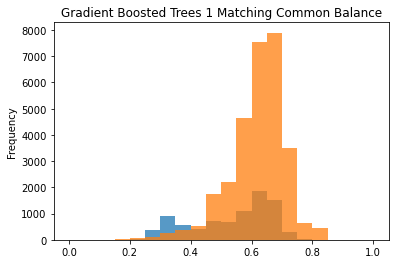

In [96]:
GBT_sr = pd.Series(trees_propensity).rename("propensity", inplace=True)
df_GBT = cleaned_df.join(GBT_sr)
matches_GBT = matching(label=treatment,
                   propensity=GBT_sr,
                   calipher=0.1,
                   replace=True)
matches_data_frame_GBT = matching_to_dataframe(match=matches_GBT,
                                           covariates=df_GBT,
                                           remove_duplicates=False)

matches_data_frame_GBT.groupby("SMS_received")["propensity"].plot(kind="hist", sharex=True, range=(0,1), bins=20, alpha=0.75, title="Gradient Boosted Trees 1 Matching Common Balance")

In [99]:
GBT_balance_table, GBT_chi = print_balance_table(matches_data_frame_GBT)
GBT_balance_table

value                        
SMS_received              0              1         
variable                  %     No.      %      No.
Gender           F    67.55  5732.0  72.16  21653.0
                 M    32.45  2754.0  27.84   8355.0
Scholarship      0    89.38  7585.0  89.96  26996.0
                 1    10.62   901.0  10.04   3012.0
Hipertension     0    70.93  6019.0  77.07  23126.0
                 1    29.07  2467.0  22.93   6882.0
Diabetes         0    93.50  7934.0  92.97  27899.0
                 1     6.50   552.0   7.03   2109.0
Alcoholism       0    97.56  8279.0  97.06  29126.0
                 1     2.44   207.0   2.94    882.0
Handcap          0    99.53  8446.0  98.61  29591.0
                 1     0.47    40.0   1.39    417.0
time_delta_weeks 0    37.37  3171.0  22.83   6850.0
                 1    17.15  1455.0  22.65   6797.0
                 2    12.63  1072.0  15.01   4503.0
                 3    13.33  1131.0  13.62   4088.0
                 4    10.35   878.0  10.31   3093.0
                 5     1.66   141.0   4.94   1483.0
                 6     0.66    56.0   4.03   1208.0
                 7     2.72   231.0   1.73    518.0
                 8     0.62    53.0   1.72    515.0
                 9     0.92    78.0   1.73    518.0
                 10    1.25   106.0   0.70    209.0
                 11    0.05     4.0   0.13     40.0
                 12    1.30   110.0   0.52    156.0
                 13     NaN     NaN   0.10     30.0
Age_decade       1     7.21   612.0   6.92   2076.0
                 2    21.86  1855.0  15.22   4566.0
                 3    16.13  1369.0  18.80   5641.0
                 4    15.60  1324.0  15.64   4694.0
                 5    14.58  1237.0  19.62   5889.0
                 6    10.00   849.0  14.86   4458.0
                 7     7.31   620.0   6.12   1837.0
                 8     5.61   476.0   2.51    753.0
                 9     1.70   144.0   0.31     94.0
No-show          No   67.26  5708.0  72.54  21768.0
                 Yes  32.74  2778.0  27.46   8240.0

In [100]:
GBT_chi

,,Chi Square,p value
Gender,Gender,68.28,<0.005
Scholarship,Scholarship,2.38,0.123
Hipertension,Hipertension,135.18,<0.005
Diabetes,Diabetes,2.73,0.098
Alcoholism,Alcoholism,5.83,0.016
Handcap,Handcap,46.77,<0.005
time_delta_weeks,time_delta_weeks,NaN,<0.005
Age_decade,Age_decade,824.16,<0.005
No-show,No-show,89.91,<0.005


In [101]:
GBT_ATE = calc_ATE(matches_data_frame_GBT)
GBT_CI = calc_bootstap_CI(matches_data_frame_GBT)

$\hat (ATE) $=-0.053

**The CI for delta is:**

[-0.2087774294670846, 0.08666666666666667]


In [102]:
res_dict['Gradient Boosted Trees Matching 1'] = [GBT_ATE, GBT_CI]

In [419]:
res_dict['Gradient Boosted Trees Matching']

[-0.052769273311232046, [-0.22790253225035834, 0.10897435897435898]]

SMS_received
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: propensity, dtype: object

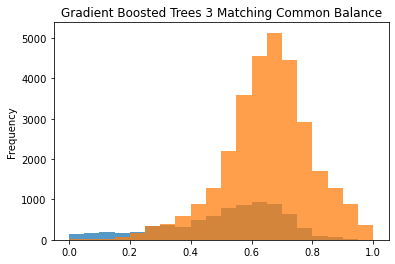

In [103]:
GBT3_sr = pd.Series(trees_propensity_3).rename("propensity", inplace=True)
df_GBT3 = cleaned_df.join(GBT3_sr)
matches_GBT3 = matching(label=treatment,
                   propensity=GBT3_sr,
                   calipher=0.1,
                   replace=True)
matches_data_frame_GBT3 = matching_to_dataframe(match=matches_GBT3,
                                           covariates=df_GBT3,
                                           remove_duplicates=False)

matches_data_frame_GBT3.groupby("SMS_received")["propensity"].plot(kind="hist", sharex=True, range=(0,1), bins=20, alpha=0.75, title="Gradient Boosted Trees 3 Matching Common Balance")

In [104]:
GBT3_balance_table, GBT3_chi = print_balance_table(matches_data_frame_GBT)
GBT3_balance_table

value                        
SMS_received              0              1         
variable                  %     No.      %      No.
Gender           F    67.55  5732.0  72.16  21653.0
                 M    32.45  2754.0  27.84   8355.0
Scholarship      0    89.38  7585.0  89.96  26996.0
                 1    10.62   901.0  10.04   3012.0
Hipertension     0    70.93  6019.0  77.07  23126.0
                 1    29.07  2467.0  22.93   6882.0
Diabetes         0    93.50  7934.0  92.97  27899.0
                 1     6.50   552.0   7.03   2109.0
Alcoholism       0    97.56  8279.0  97.06  29126.0
                 1     2.44   207.0   2.94    882.0
Handcap          0    99.53  8446.0  98.61  29591.0
                 1     0.47    40.0   1.39    417.0
time_delta_weeks 0    37.37  3171.0  22.83   6850.0
                 1    17.15  1455.0  22.65   6797.0
                 2    12.63  1072.0  15.01   4503.0
                 3    13.33  1131.0  13.62   4088.0
                 4    10.35   878.0  10.31   3093.0
                 5     1.66   141.0   4.94   1483.0
                 6     0.66    56.0   4.03   1208.0
                 7     2.72   231.0   1.73    518.0
                 8     0.62    53.0   1.72    515.0
                 9     0.92    78.0   1.73    518.0
                 10    1.25   106.0   0.70    209.0
                 11    0.05     4.0   0.13     40.0
                 12    1.30   110.0   0.52    156.0
                 13     NaN     NaN   0.10     30.0
Age_decade       1     7.21   612.0   6.92   2076.0
                 2    21.86  1855.0  15.22   4566.0
                 3    16.13  1369.0  18.80   5641.0
                 4    15.60  1324.0  15.64   4694.0
                 5    14.58  1237.0  19.62   5889.0
                 6    10.00   849.0  14.86   4458.0
                 7     7.31   620.0   6.12   1837.0
                 8     5.61   476.0   2.51    753.0
                 9     1.70   144.0   0.31     94.0
No-show          No   67.26  5708.0  72.54  21768.0
                 Yes  32.74  2778.0  27.46   8240.0

In [105]:
GBT3_chi

,,Chi Square,p value
Gender,Gender,68.28,<0.005
Scholarship,Scholarship,2.38,0.123
Hipertension,Hipertension,135.18,<0.005
Diabetes,Diabetes,2.73,0.098
Alcoholism,Alcoholism,5.83,0.016
Handcap,Handcap,46.77,<0.005
time_delta_weeks,time_delta_weeks,NaN,<0.005
Age_decade,Age_decade,824.16,<0.005
No-show,No-show,89.91,<0.005


In [107]:
GBT3_ATE = calc_ATE(matches_data_frame_GBT3)
GBT3_CI = calc_bootstap_CI(matches_data_frame_GBT3)

$\hat (ATE) $=-0.028

**The CI for delta is:**

[-0.18181818181818182, 0.12606921963416237]


In [108]:
res_dict['Gradient Boosted Trees Matching 3'] = [GBT3_ATE, GBT3_CI]

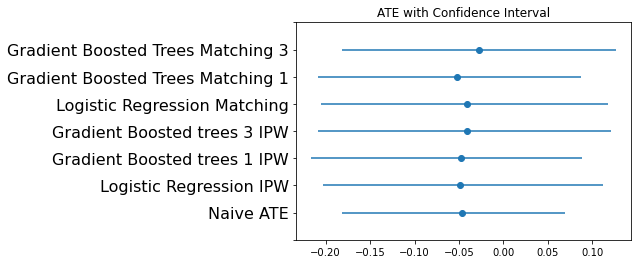

In [109]:
x = []
errors = []
est = []
y = [1,2,3,4,5,6,7]
for key, val in res_dict.items():
    x.append(np.mean(val[1]))
    errors.append((val[1][1]-val[1][0])/2)
    est.append(val[0])
plt.errorbar(x, y, xerr=errors, linestyle = 'None')
plt.scatter(est,y)
    
#plt.legend(fontsize=16)
plt.yticks((0, 1, 2, 3, 4, 5, 6,7,8), ('', *res_dict.keys(),''),fontsize=16)
plt.title('ATE with Confidence Interval')
plt.show()

In [427]:
x

[-0.05254793944875345,
 -0.049892884709609626,
 -0.037339191537379406,
 -0.03844320236725299,
 -0.05946408663799968]

In [426]:
errors

[0.2403586665570386,
 0.28135727090086965,
 0.29972378953290096,
 0.31618718833908704,
 0.3368768912247173]

In [123]:
res_dict_mod = {}
for key, value in res_dict.items():
    res_dict_mod[key] = [value[0]] + value[1]
res_pd = pd.DataFrame.from_dict(res_dict_mod).T
res_pd

,0,1,2
Naive ATE,-0.046241,-0.182097,0.068747
Logistic Regression IPW,-0.049376,-0.203187,0.112313
Gradient Boosted trees 1 IPW,-0.047299,-0.216412,0.088801
Gradient Boosted trees 3 IPW,-0.041084,-0.208962,0.121299
Logistic Regression Matching,-0.041135,-0.205439,0.117369
Gradient Boosted Trees Matching 1,-0.052769,-0.208777,0.086667
Gradient Boosted Trees Matching 3,-0.027564,-0.181818,0.126069
